### 1. Data Discovery

In [3]:
# 1. Load all Libraries/Datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import math

import pickle 
# For serializing and de-serializing a python object structure. Any object in python can be pickled so that it can
# be saved on disk. Pickling is a way to convert a python object ( list, dict, etc. ) into a character stream which
# contains all the information necessary to reconstruct the object in another python script. 

ds1 = pd.read_csv( "gt_2011.csv" )
ds2 = pd.read_csv( "gt_2012.csv" )
ds3 = pd.read_csv( "gt_2013.csv" )
ds4 = pd.read_csv( "gt_2014.csv" )
ds5 = pd.read_csv( "gt_2015.csv" )

In [4]:
# 2. Concatenate all dataframes
frames = [ ds1, ds2, ds3, ds4, ds5 ]
merged_ds = pd.concat( frames )

# Saving merged ds into a separate .csv file for ease
pd.DataFrame.to_csv( merged_ds, "CombinedDataSet.csv", index=False )

merged_ds.head( )

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  
0  0.32663  81.952  
1  0.44784  82.377  
2  0.45144  83.776  
3  0.23107  82.505  
4  0.26747  82.028

In [39]:
# 3. Evalutate shape and size of combined Dataset
merged_ds.shape
merged_ds.size

404063

In [22]:
# 4.Use the .info() method to see the type of all features and whether there is any null or 
# missing value in your dataset. 

merged_ds.info( )

<class 'pandas.core.frame.DataFrame'>
Index: 36733 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.4 MB


In [56]:
# 5. Get the general statistical description (.describe()) of your dataframe and report your
# observations. Can you find any skewness at this point, based on the comparison of mode,
# and mean. 

mean_values = merged_ds.describe(include="all").loc['mean']
median_values = merged_ds.median(axis="index")

# Creating a new DataFrame with mean and median
summary_table = pd.DataFrame({
    'Feature': mean_values.index,
    'Mean': mean_values.values,
    'Median': median_values.values
})

# Display the table
print(summary_table)

   Feature         Mean     Median
0       AT    17.712726    17.8010
1       AP  1013.070165  1012.6000
2       AH    77.867015    80.4700
3     AFDP     3.925518     3.9377
4     GTEP    25.563801    25.1040
5      TIT  1081.428084  1085.9000
6      TAT   546.158517   549.8800
7      TEY   133.506404   133.7300
8      CDP    12.060525    11.9650
9       CO     2.372468     1.7135
10     NOX    65.293067    63.8490


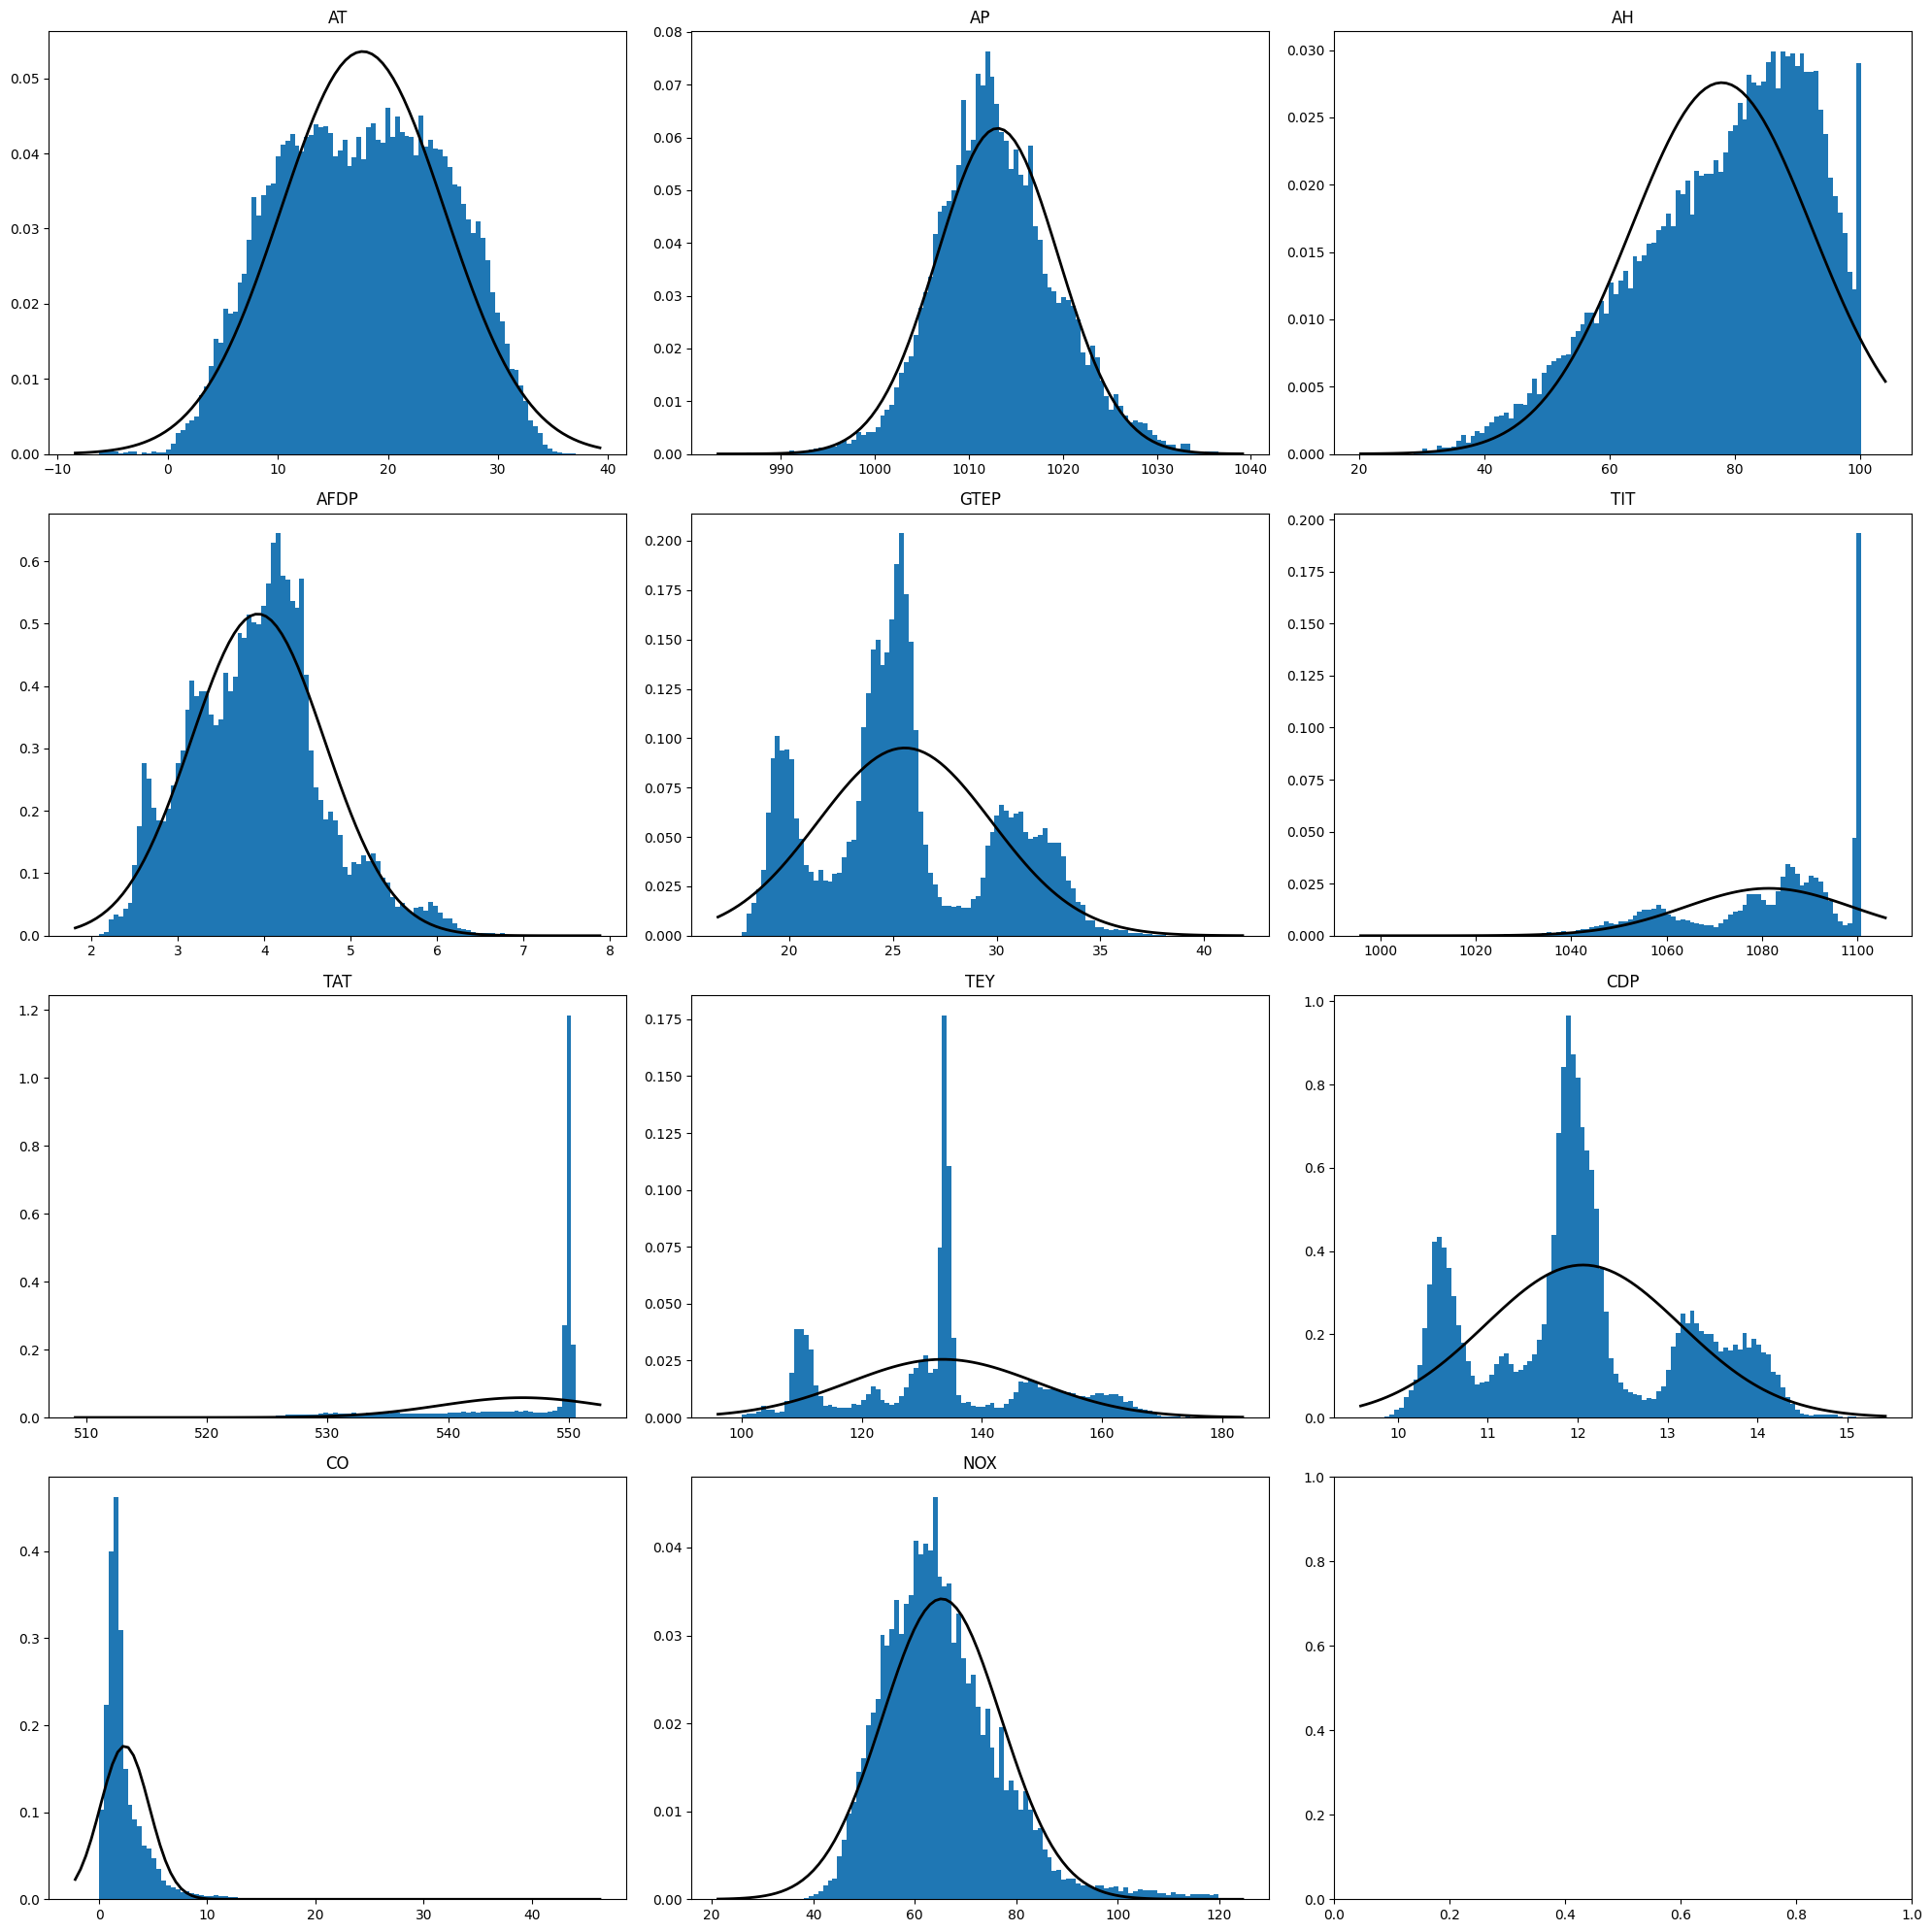

In [55]:
# 6. Plot histogram of all variables

# merged_ds.hist(layout=(4, 3), figsize=(20, 25), bins=100 ) # 1 row, 3 columns layout
# Columns you want to plot
columns = [ "AT", "AP",	"AH", "AFDP", "GTEP", "TIT", "TAT", "TEY", "CDP", "CO", "NOX" ]  # Replace with your actual column names

# Determine the layout size
n_cols = 3  # Number of columns in the layout
n_rows = int(np.ceil(len(columns) / n_cols))

# Create a figure and axes for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the columns and corresponding axes
for ax, column in zip(axes, columns):
    # Extract data for the column
    data = merged_ds[column]

    # Fit a normal distribution to the data
    mu, std = stats.norm.fit(data)

    # Plot the histogram
    ax.hist(data, bins=100, density=True )

    # Plot the PDF
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)

    # Set title
    ax.set_title(f"{column}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [65]:
# 7 A) Calculate the correlation matrix and sort it based on the correlation of Turbine
# energy yield (TEY) with other features. Report your observations. (4 points)

corr_mat = merged_ds.corr( )
corr_mat[ "TEY" ].sort_values( ascending=False )

NOX     1.000000
CO      0.340606
AP      0.191938
AH      0.164617
TAT    -0.092791
TEY    -0.116127
CDP    -0.171256
AFDP   -0.188247
GTEP   -0.201630
TIT    -0.213865
AT     -0.558174
Name: NOX, dtype: float64

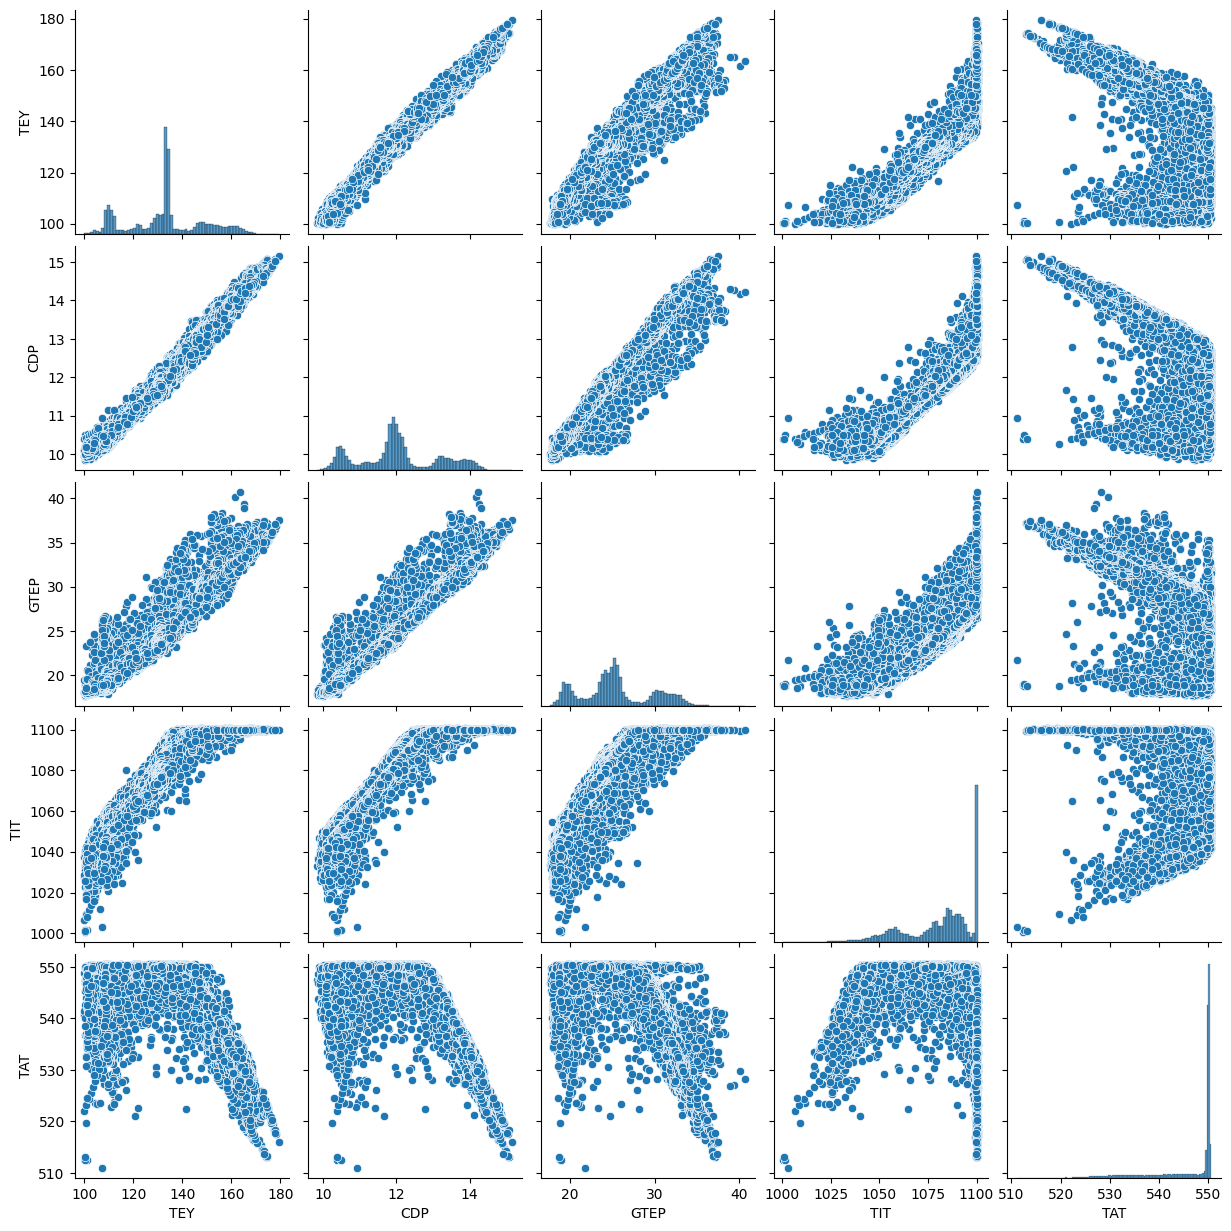

In [69]:
# 7 B) Select the top 4 mostly correlated features F1 – F8 (consider the magnitude of
# pearson’s coef. of each feature not its sign) with TEY and generate a pairplot plot
# for them(seaborn.pairplot()). (4 points)

subset_ds = merged_ds[ ["TEY"] + [ "CDP", "GTEP", "TIT", "TAT" ] ]
sns.pairplot( subset_ds )

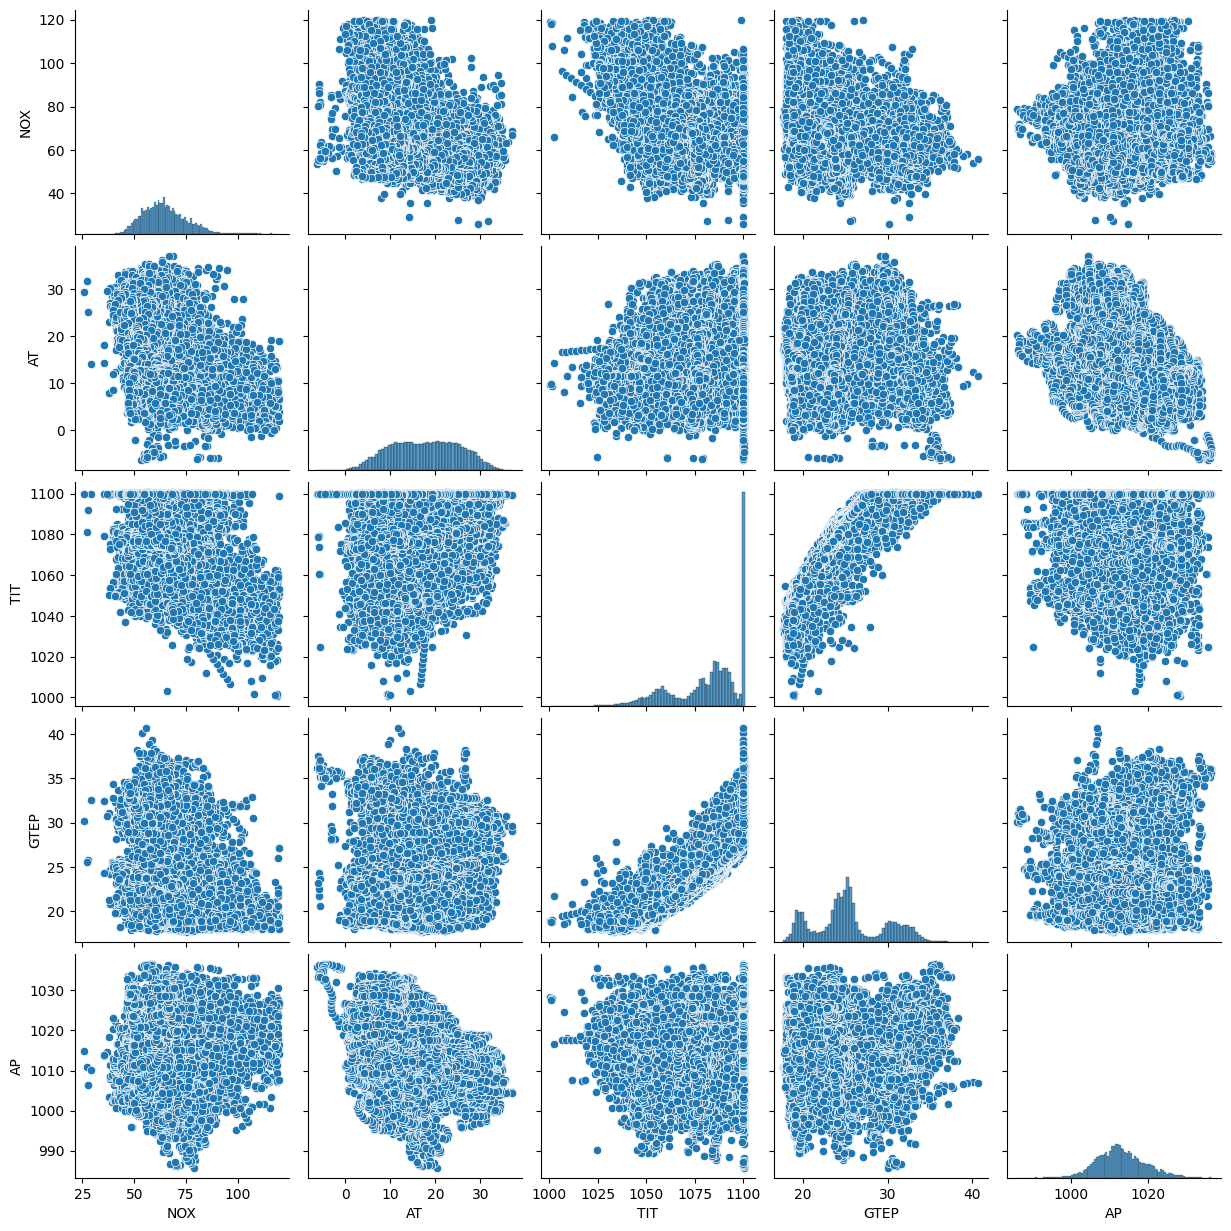

In [72]:
# 7 C) Repeat the above steps for CO and NOX emissions

corr_mat[ "CO" ].sort_values( ascending=False )
corr_mat[ "NOX" ].sort_values( ascending=False )

subset_ds = merged_ds[ ["CO"] + [ "TIT", "CDP", "GTEP", "AFDP" ] ]
subset_ds = merged_ds[ ["NOX"] + [ "AT", "TIT", "GTEP", "AP" ] ]
sns.pairplot( subset_ds )

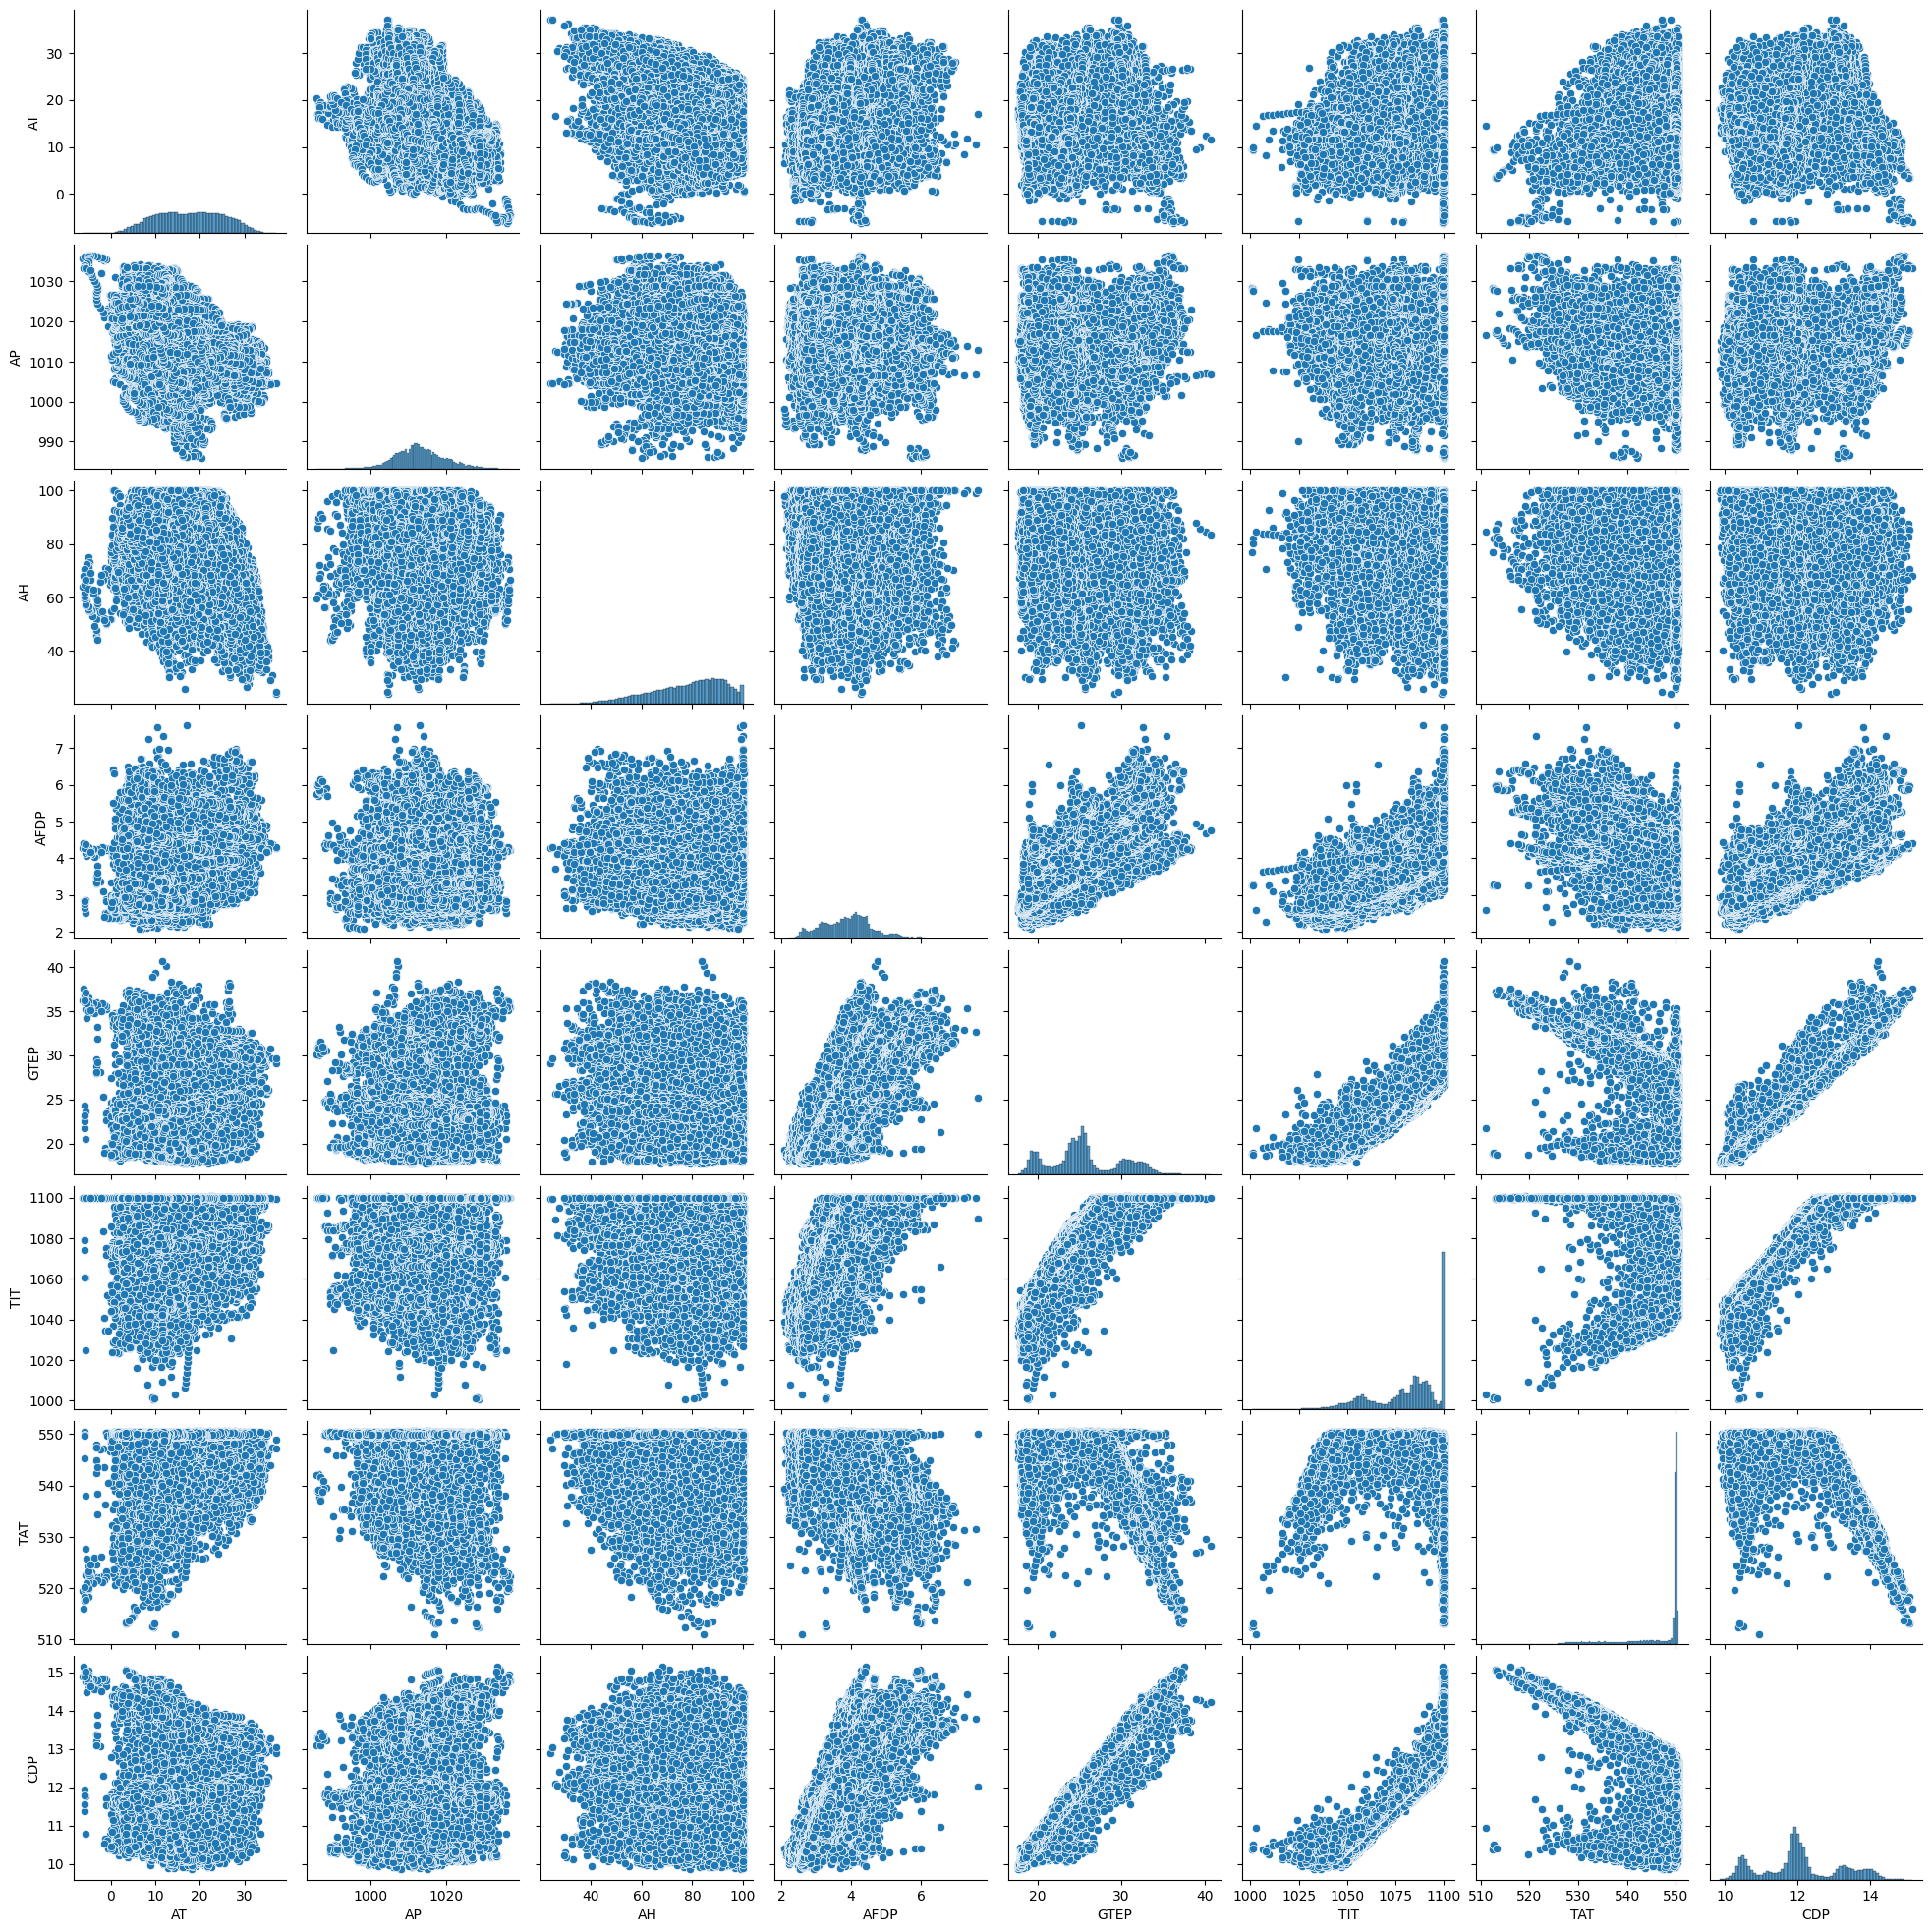

In [74]:
# 8. Create a sub-dataframe of features only, named features_sub. Generate a pairplot for
# them. Do you see any strong inter-relationship between the features? If yes, what
# features do you guess are a proper choice for combination and creating new features
# based on their relation? (3points)

features_sub = merged_ds[ [ "AT", "AP", "AH", "AFDP", "GTEP", "TIT", "TAT", "CDP" ] ]
sns.pairplot( features_sub )


In [5]:
# 9. Split the data into training ( 80 % ) and test set ( 20 % )
x = merged_ds.iloc[ :, [ 0, 1, 2, 3, 4, 5, 6, 8 ] ].values
y = merged_ds.iloc[ :, [ 7, 9, 10 ] ].values

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2 )